In [1]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
import random 
import pickle
from matplotlib.pyplot import figure
import time
from tqdm import tqdm

from stoc_match import StochasticMatching, Aggregation

# System and settings

In [2]:
verteces = ['A', 'B', 'C', 'D']


graph = {
    'A': [('B', 200), ('C', 10), ('D', 50)],
    'B': [('A', 200), ('D', 20)],
    'C': [('A', 10), ('D', 1)],
    'D': [('A', 50), ('B', 20), ('C', 1)]
}

arrival_rates = {
    'A': 0.9,
    'B': 0.2,
    'C': 0.5,
    'D': 0.6
}

arrival_rates_ind = {}
for ind, vertex in zip(list(range(len(arrival_rates))), arrival_rates.keys()):
    arrival_rates_ind[ind] = arrival_rates[vertex]

    
verteces_ind = {'A': 0,
               'B': 1,
               'C': 2,
               'D': 3
               }


eta = 0.5
discount = 0.8
H = 50
k = 10


experts = ['match_the_longest', 'edge_priority_match_reward', 'random_match']
queue_max = 5

queues ={v: [] for v in verteces}


state_space = list(itertools.product(np.array(range(queue_max + 1)), repeat=len(graph.keys())))

n = 0
state_space_ind = {}
for s in state_space:
    state_space_ind[str(n)] = s
    n += 1 
    
exp_ind = {}
n = 0
for exp in experts:
    exp_ind[str(n)] = exp
    n += 1 
    
prob_arrival = []
N =np.sum(np.array(list(arrival_rates.values())))

for rate in arrival_rates.values():
    prob_arrival.append(rate/N) 
    
num_states = len(state_space)
num_exp = len(experts)

edges = [(u, v, w) for u in graph for v, w in graph[u]]
edges_list = []

    
rewards_ind = {}

for edge in edges:
    e=[]
    e.append(verteces_ind[np.array(edge)[0]])
    e.append(verteces_ind[np.array(edge)[1]])
    if [verteces_ind[np.array(edge)[1]], verteces_ind[np.array(edge)[0]]] not in edges_list:
        edges_list.append(e)
        rewards_ind[str(e)] = edge[2]
    
num_actions = len(edges_list) + 1

state_action_space_ind = {}
n = 0
for s in state_space:
    for a in edges_list:
        state_action_space_ind[str(n)] = [s, a]
        n += 1 

key_list = list(state_space_ind.keys())
val_list = list(state_space_ind.values())

K = len(experts)    

edges_ind = {}

for edge, i in zip(edges_list, list(range(len(edges_list)))):
    edges_ind[i] = edge
edges_ind[len(edges_list)] = 'no_move'

### Policies

In [3]:
def match_the_longest(edges_list, state):
    selected_edges = []
    edge_max = - np.inf
    for edge in edges_list: 
        if (np.array(state)[edge[0]] > 0)  and (np.array(state)[edge[1]] > 0):
            if (np.array(state)[edge[0]] + np.array(state)[edge[1]]) > edge_max: 
                edge_max = np.array(state)[edge[0]] + np.array(state)[edge[1]]
                selected_edges = []
                selected_edges.append(edge)
            #elif np.array(state)[edge[0]] + np.array(state)[edge[1]] == edge_max:
            #    selected_edges.append(edge)
    return selected_edges

def edge_priority_match_reward(edges_list, state):
    selected_edges = []
    edge_max = - np.inf
    for edge in edges_list: 
        if (np.array(state)[edge[0]] > 0)  and (np.array(state)[edge[1]] > 0):
            if rewards_ind[str(edge)] > edge_max: 
                edge_max = rewards_ind[str(edge)]
                selected_edges = []
                selected_edges.append(edge)
            #elif rewards_ind[str(edge)] == edge_max:
            #    selected_edges.append(edge)
    return selected_edges

def random_match(edges_list, state):
    selected_edges = []
    #edges_list_random = edges_list.copy()
    #random.shuffle(edges_list_random)
    for edge in edges_list: 
        if (np.array(state)[edge[0]] > 0)  and (np.array(state)[edge[1]] > 0):
            #selected_edges = []
            selected_edges.append(edge)
            #break
    return selected_edges

def edge_priority_match_arrival_rate_low(edges_list, state):
    selected_edges = []
    edge_min = np.inf
    for edge in edges_list: 
        if (np.array(state)[edge[0]] > 0)  and (np.array(state)[edge[1]] > 0):
            if (arrival_rates_ind[edge[0]] + arrival_rates_ind[edge[1]]) < edge_min: 
                edge_min = arrival_rates_ind[edge[0]] + arrival_rates_ind[edge[1]] 
                selected_edges = []
                selected_edges.append(edge)
            #elif (arrival_rates_ind[edge[0]] + arrival_rates_ind[edge[1]]) == edge_min:
            #    selected_edges.append(edge)
    return selected_edges

def edge_priority_match_arrival_rate_high(edges_list, state):
    selected_edges = []
    edge_max = - np.inf
    for edge in edges_list: 
        if (np.array(state)[edge[0]] > 0)  and (np.array(state)[edge[1]] > 0):
            if (arrival_rates_ind[edge[0]] + arrival_rates_ind[edge[1]]) > edge_max: 
                edge_max = arrival_rates_ind[edge[0]] + arrival_rates_ind[edge[1]] 
                selected_edges = []
                selected_edges.append(edge)
            #elif (arrival_rates_ind[edge[0]] + arrival_rates_ind[edge[1]]) == edge_max:
            #    selected_edges.append(edge)
    return selected_edges

def edge_priority_match_random(edges_list, state):
    selected_edges = []
    edge_max = - np.inf
    edges_list_ordered = edges_list.copy()
    random.seed(11)
    random.shuffle(edges_list_ordered)
    for edge in edges_list_ordered: 
        if (np.array(state)[edge[0]] > 0)  and (np.array(state)[edge[1]] > 0):
            arrival_rates_ind[edge[0]] + arrival_rates_ind[edge[1]] 
            selected_edges.append(edge)
            break
    return selected_edges

experts_dict = {'match_the_longest': match_the_longest,
                'edge_priority_match_reward' : edge_priority_match_reward,
                'random_match': random_match,
                
                   } 
exp_ind = {'match_the_longest': 0,
         'edge_priority_match_reward' : 1,
         'random_match': 2,
         } 



# Transition matrix and rewards

In [4]:
cLI = (eta * queue_max * len(verteces))


def compute_transitions_and_rewards_avg(weights):
    P = np.zeros((num_states, num_states))
    r = np.zeros(num_states)
                       
    for index, state in state_space_ind.items():
        selected_edges_experts = {exp: [] for exp in experts} 
        for exp in experts: 
            selected_edges_experts[exp] = experts_dict[exp](edges_list, state)
            if selected_edges_experts[exp]: 
                num_edges = len(selected_edges_experts[exp])
                for edge in selected_edges_experts[exp]:
                    q1 = edge[0]
                    q2 = edge[1]
                    new_state = np.array(state).copy()
                    new_state[q1] -= 1
                    new_state[q2] -= 1
                    sum_queues = np.sum(new_state)
                    for q in range(len(new_state)):
                        if np.array(new_state)[q] < queue_max:
                            new_state_after_arr = new_state.copy()
                            new_state_after_arr[q] += 1
                            new_state_after_arr = tuple(new_state_after_arr)
                            index_new = int(val_list.index(new_state_after_arr))
                            P[int(index), index_new] += weights[index][exp_ind[exp]] * (1 / num_edges) * prob_arrival[q]
                            r[int(index)] += prob_arrival[q] * weights[index][exp_ind[exp]] * (1 / num_edges) * (rewards_ind[str(edge)] - eta * sum_queues)
                        else:           
                            new_state_after_arr = new_state.copy()
                            index_new = int(val_list.index(tuple(new_state_after_arr)))
                            P[int(index), index_new] += weights[index][exp_ind[exp]] * (1 / num_edges) * prob_arrival[q]
                            r[int(index)] += weights[index][exp_ind[exp]] * (rewards_ind[str(edge)] - eta * sum_queues) * prob_arrival[q]* (1 / num_edges) 
            else:
                for q in range(len(state)):
                    if np.array(state)[q] < queue_max:
                        new_state = np.array(state) 
                        new_state[q] += 1
                        sum_queues = np.sum(state)
                        new_state = tuple(new_state)
                        index_new = int(val_list.index(new_state))
                        P[int(index), index_new] += weights[index][exp_ind[exp]]  * prob_arrival[q]
                        r[int(index)] += weights[index][exp_ind[exp]] * (- eta * sum_queues) * prob_arrival[q]
                    else:           
                        sum_queues = np.sum(state)
                        P[int(index), int(index)] += weights[index][exp_ind[exp]] * prob_arrival[q]
                        r[int(index)] += weights[index][exp_ind[exp]] * (- eta * sum_queues) * prob_arrival[q] 
    #normalise rewards
    r_norm = r + cLI
    # check
    for s in range(len(state_space)):
        if np.abs(np.sum(P[s,:]) - 1) > 1e-5:
            print('Error: transition probabilities do not some to 1', np.sum(P[s,:]), s)
        return P, r_norm
    

def compute_transitions_and_rewards_experts():
    P = np.zeros((num_states, num_exp, num_states))
    r = np.zeros((num_states, num_exp, num_states))
    
    for index, state in state_space_ind.items():
        for exp in experts: 
            selected_edges_experts = experts_dict[exp](edges_list, state)
            if selected_edges_experts: 
                num_edges = len(selected_edges_experts)
                for edge in selected_edges_experts:
                    q1 = edge[0]
                    q2 = edge[1]
                    new_state = np.array(state).copy()
                    new_state[q1] -= 1
                    new_state[q2] -= 1
                    sum_queues = np.sum(new_state)
                    for q in range(len(new_state)):
                        if np.array(new_state)[q] < queue_max:
                            new_state_after_arr = new_state.copy()
                            new_state_after_arr[q] += 1
                            new_state_after_arr = tuple(new_state_after_arr)
                            index_new = int(val_list.index(new_state_after_arr))
                            P[int(index), exp_ind[exp], index_new] += (1 / num_edges) * prob_arrival[q]
                            r[int(index), exp_ind[exp], index_new] += (1 / num_edges) * (rewards_ind[str(edge)] - eta * sum_queues) 
                        else:            
                            new_state_after_arr = new_state.copy()
                            index_new = int(val_list.index(tuple(new_state_after_arr)))
                            P[int(index), exp_ind[exp], index_new] += 1 / num_edges * prob_arrival[q]
                            r[int(index), exp_ind[exp], index_new] += (1 / num_edges) *(rewards_ind[str(edge)] - eta * sum_queues)      
            else:
                for q in range(len(state)):
                    if np.array(state)[q] < queue_max:
                        new_state = np.array(state).copy()
                        new_state[q] += 1
                        sum_queues = np.sum(state)
                        new_state = tuple(new_state)
                        index_new = int(val_list.index(new_state))
                        P[int(index),  exp_ind[exp], index_new] += prob_arrival[q]
                        r[int(index),  exp_ind[exp], index_new] += - eta * sum_queues 
                    else:           
                        sum_queues = np.sum(state)
                        P[int(index), exp_ind[exp], int(index)] += prob_arrival[q]
                        r[int(index), exp_ind[exp], int(index)] = (- eta * sum_queues)
                        
    #normalise rewards
    r_norm = r + cLI
    # check
    for s in range(num_states):
        for e in range(num_exp):
            if np.abs(np.sum(P[s,e, :]) - 1) > 1e-5:
                print('Error: transition probabilities do not some to 1', np.sum(P[s,:]), s)
    return P, r_norm

def compute_transitions_and_rewards_actions():
    P = np.zeros((num_states, num_actions, num_states))
    r = np.zeros((num_states, num_actions, num_states))
    
    for index, state in state_space_ind.items():
        potential_matches = 0
        for ind, edge in edges_ind.items():
            if edge != 'no_move':
                if (np.array(state)[edge[0]] > 0)  and (np.array(state)[edge[1]] > 0):
                    potential_matches += 1
                    q1 = edge[0]
                    q2 = edge[1]
                    new_state = np.array(state).copy()
                    new_state[q1] -= 1
                    new_state[q2] -= 1
                    sum_queues = np.sum(new_state)
                    for q in range(len(new_state)):
                        if np.array(new_state)[q] < queue_max:
                            new_state_after_arr = new_state.copy()
                            new_state_after_arr[q] += 1
                            new_state_after_arr = tuple(new_state_after_arr)
                            index_new = int(val_list.index(new_state_after_arr))
                            P[int(index),  ind, index_new] += prob_arrival[q]
                            r[int(index), ind, index_new] +=  rewards_ind[str(edge)] - eta * sum_queues 
                        else:           
                            index_new = int(val_list.index(tuple(new_state)))
                            P[int(index), ind, index_new] += prob_arrival[q]
                            r[int(index), ind, index_new] = rewards_ind[str(edge)] - eta * sum_queues
    #check
            elif edge == 'no_move':
                if potential_matches==0:
                    for q in range(len(state)):
                        if np.array(state)[q] < queue_max:
                            new_state = np.array(state) 
                            new_state[q] += 1
                            sum_queues = np.sum(state)
                            new_state = tuple(new_state)
                            index_new = int(val_list.index(new_state))
                            P[int(index),  ind, index_new] += prob_arrival[q]
                            r[int(index),  ind, index_new] += - eta * sum_queues 
                        else:           
                            sum_queues = np.sum(state)
                            P[int(index), ind, int(index)] += prob_arrival[q]
                            r[int(index), ind, int(index)] = - eta * sum_queues 
                        
    #normalise rewards
    r_norm = r + cLI
    #check
    for s in range(num_states):
        for e in range(num_exp):
            if (np.abs(np.sum(P[s,e, :]) - 1) > 1e-5) and (np.sum(P[s,e, :]) != 0):
                print('Error: transition probabilities do not some to 1', np.sum(P[s,:]), s)
    
    return P, r_norm
                        
def compute_value_bellman(P, r):
    I = np.eye(num_states)
    inv = np.linalg.inv(I - discount*P)
    V = np.matmul(inv, r)
    return V

# Q-learning

In [5]:
weights = {state: np.array([0, 1, 0]) for state in state_space_ind.keys()}

P_agg, r_agg = compute_transitions_and_rewards_avg(weights)
V_agg = compute_value_bellman(P_agg, r_agg)

Q_start = np.zeros((num_states, num_actions))
for state in range(num_states):
    Q_start[state, :] = V_agg[state] 

In [6]:
%%time
num_episodes = 8000
steps = 50000000
num_actions = len(edges_list) + 1
num_states = len(state_space)
learning_rate = 1e-4
start_learning_rate_decay = 1
end_learning_rate_decay = steps 
learning_rate_decay_value = learning_rate / (end_learning_rate_decay - start_learning_rate_decay)

repeat_ql = 10

epsilon = 0.001
start_epsilon_decay = 1
end_epsilon_decay = steps # provare senza / 2
epsilon_decay_value = epsilon / (end_epsilon_decay - start_epsilon_decay)

model = StochasticMatching(graph, arrival_rates, queue_max)
Q_evolution = []
time_QL = []
time_tot = 0
res = 100000

for n in range(repeat_ql):
    Q = Q_start.copy()
    Q_evolution = []
    time_QL = []
    time_tot = 0
    epsilon = 0.1
    learning_rate = 15e-5
    model = StochasticMatching(graph, arrival_rates, queue_max)
    state = int(model.val_list.index(state_space[0]))
    for step in tqdm(range(steps)):
        start_time = time.time()
        new_Q, new_state = model.q_learning(Q, state, learning_rate, discount, epsilon, eta, steps)
        end_time = time.time()
        time_tot += end_time - start_time
        Q = new_Q.copy()
        state = new_state
        if end_epsilon_decay >= step >= start_epsilon_decay:
            epsilon -= epsilon_decay_value
        if end_learning_rate_decay >= step >= start_learning_rate_decay:
            learning_rate -= learning_rate_decay_value
        if step%res == 0:
            Q_max = 0
            for i in range(len(verteces)):
                s = np.zeros(len(verteces))
                s[i] += 1
                ind = str(val_list.index(tuple(s)))
                Q_max += prob_arrival[i] * max(new_Q[int(ind)])
            Q_evolution.append(Q_max)
            time_QL.append(time_tot)
            #if step % (res * 100) == 0:
            #    print('step -> ',n, step)
            
    with open('weights/QL1_' + str(n) + '.pkl', 'wb') as output:
        pickle.dump(Q_evolution, output)
    with open('weights/time_QL1_' + str(n) + '.pkl', 'wb') as output:
        pickle.dump(time_QL, output)
            

100%|████████████████████████████| 50000000/50000000 [59:33<00:00, 13990.56it/s]

CPU times: user 9h 52min 32s, sys: 2min 9s, total: 9h 54min 42s
Wall time: 19h 44min 48s


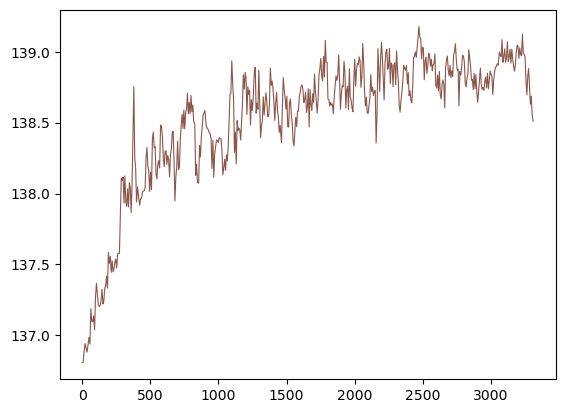

In [7]:
plt.plot(time_QL, Q_evolution, color='C5', linewidth=.8)